In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from arch import arch_model
from IPython.display import display

import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

__1.__ Будем работать с данными по индексу [S&P](https://ru.wikipedia.org/wiki/S%26P_500). Для начала загрузим данные.

In [17]:
data = pd.read_csv('spx.csv').sort_values('Date').set_index('Date').fillna(0)

In [5]:
data.head()

,Date,spx_ret
0,1994-01-06,NaN
1,1994-01-07,0.595136
2,1994-01-10,1.142795
3,1994-01-11,-0.239860
4,1994-01-12,0.008438


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6692 entries, 1970-01-01 00:00:00 to 1970-01-01 00:00:00.000006691
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     6692 non-null   object 
 1   spx_ret  6691 non-null   float64
dtypes: float64(1), object(1)
memory usage: 156.8+ KB


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6692 entries, 1994-01-06 to 2019-08-30
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   spx_ret  6692 non-null   float64
dtypes: float64(1)
memory usage: 104.6 KB


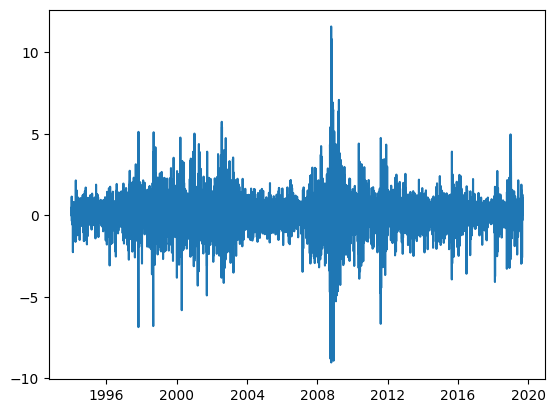

In [18]:
data.index = pd.to_datetime(data.index)
plt.plot(data.spx_ret)
data.info()

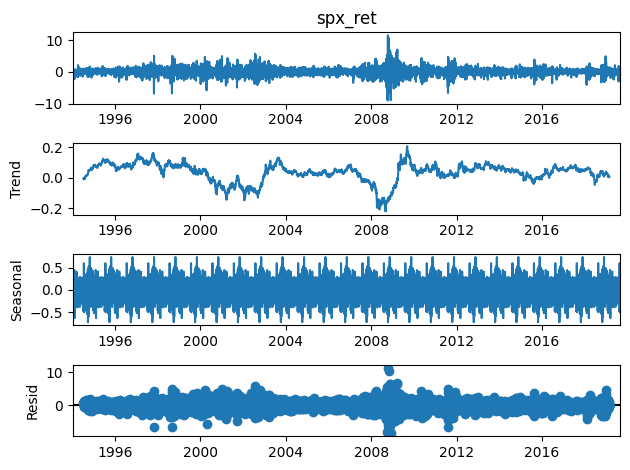

In [19]:
seasonal_decompose(data.spx_ret, period=262).plot()
plt.show()

__2.__ Разделите данные на `train` и `test`, так, чтобы в `train` оказались значения до `2018` года включительно.

In [41]:
train = data.loc[:pd.Timestamp('2018-12-31')].reset_index()
test = data.loc[pd.Timestamp('2019-01-01'):].reset_index()

print("Конец трейна:")
display(train.tail())
print("Начало теста:")
display(test.head())

Конец трейна:


,Date,spx_ret
6513,2018-12-25,0.000000
6514,2018-12-26,4.959374
6515,2018-12-27,0.856268
6516,2018-12-28,-0.124158
6517,2018-12-31,0.849248


Начало теста:


,Date,spx_ret
0,2019-01-01,0.000000
1,2019-01-02,0.126850
2,2019-01-03,-2.475673
3,2019-01-04,3.433571
4,2019-01-07,0.701043


__3.__ Заметим, что временной ряд предварительно обработан. Проверьте, является ли ряд стационарным? Постройте графики `PACF` и `ACF`, обучите `ARMA`-модель с оптимальными гиперпараметрами. 

*Замечание. Аккуратно подойдите к выбору параметров $p$ и $q$, не стоит брать их слишком большими, несмотря на то, что последние пики `PACF` и `ACF` могут соответствовать большим лагам.*

In [29]:
from collections import Counter
print(Counter([i.year for i in train.Date]))
print(Counter([i.month for i in train.Date]))

Counter({1996: 262, 2004: 262, 2008: 262, 1997: 261, 1998: 261, 1999: 261, 2001: 261, 2002: 261, 2003: 261, 2007: 261, 2009: 261, 2010: 261, 2012: 261, 2013: 261, 2014: 261, 2015: 261, 2016: 261, 2018: 261, 1995: 260, 2000: 260, 2005: 260, 2006: 260, 2011: 260, 2017: 260, 1994: 257})
Counter({5: 555, 8: 555, 3: 554, 10: 554, 7: 552, 12: 552, 1: 550, 6: 536, 11: 536, 9: 535, 4: 534, 2: 505})


Во временном ряду только рабочие дни судя по количеству дней в году. Месячная сезонность в итоге 21-22 дня.

In [32]:
print(f"Значение p-value для KPSS: {kpss(data.spx_ret)[1]}, не можем откинуть гипотезу о нестационарности ряда (можем сказать что ряд стационарен)")
print()
print(f"Значение p-value для Дики-Фуллера: {adfuller(data.spx_ret)[1]}")

Значение p-value для KPSS: 0.1, не можем откинуть гипотезу о нестационарности ряда (можем сказать что ряд стационарен)

Значение p-value для Дики-Фуллера: 2.3645927585670867e-27


По p-value видно, что один критерий не отверг стационарность ряда, а другой отверг не стационарность, значит можем считать ряд стационарным.

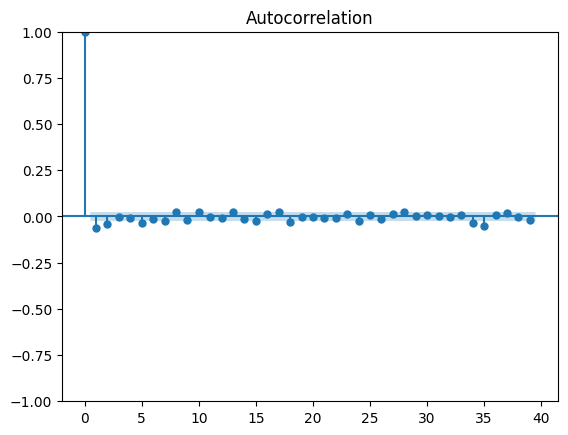

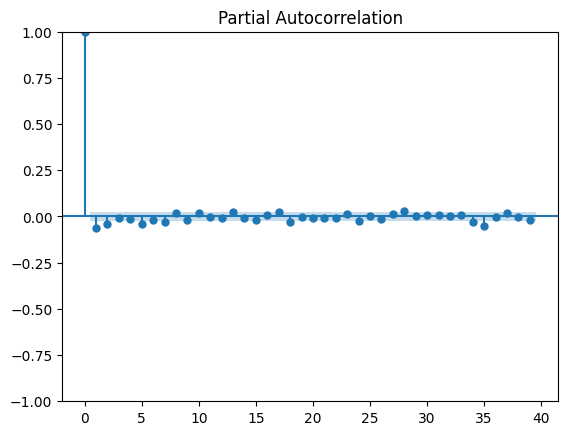

In [33]:
plot_acf(data.spx_ret)
plot_pacf(data.spx_ret)
plt.show()

In [35]:
%%time 
model = SARIMAX(train.spx_ret, order=(35, 1, 35), seasonal_order=(0, 1, 0, 21), simple_differencing=True).fit(disp=0)
print(model.summary())

                                       SARIMAX Results                                       
Dep. Variable:                        D.DS21.spx_ret   No. Observations:                 6496
Model:             SARIMAX(35, 0, 35)x(0, 0, [], 21)   Log Likelihood              -10069.264
Date:                               Tue, 21 Mar 2023   AIC                          20280.529
Time:                                       00:01:32   BIC                          20761.833
Sample:                                            0   HQIC                         20447.003
                                              - 6496                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1032      0.808     -1.365      0.172      -2.688       0.481
ar.L2      

In [36]:
%%time
arima = auto_arima(y=train.spx_ret, start_p=1, start_q=1, max_p=5, max_d=2, max_q=5, start_P=1, start_Q=1, max_P=2, max_D=2, max_Q=2, m=21)
arima.to_dict()

CPU times: user 2min 47s, sys: 6min 51s, total: 9min 38s
Wall time: 44.2 s


{'pvalues': intercept    2.063280e-02
 ar.L1        2.986073e-51
 ma.L1        3.272669e-74
 sigma2       0.000000e+00
 dtype: float64,
 'resid': 0      -0.032084
 1       0.561228
 2       1.142705
 3      -0.181644
 4       0.025341
           ...   
 6513   -0.433333
 6514    4.633581
 6515    0.915007
 6516   -0.039299
 6517    0.892536
 Length: 6518, dtype: float64,
 'order': (1, 0, 1),
 'seasonal_order': (0, 0, 0, 21),
 'oob': nan,
 'aic': 20052.13019114439,
 'aicc': 20052.136332707418,
 'bic': 20079.259482581983,
 'bse': intercept    0.004640
 ar.L1        0.044176
 ma.L1        0.039893
 sigma2       0.009966
 dtype: float64,
 'params': intercept    0.010739
 ar.L1        0.665277
 ma.L1       -0.727048
 sigma2       1.267833
 dtype: float64}

С помощью получившейся модели постройте предсказания для теста и `95`-процентный доверительный интервал для них. 

In [37]:
preds, ci = arima.fit(y=train.spx_ret).predict(len(test), return_conf_int=True, alpha=0.05)

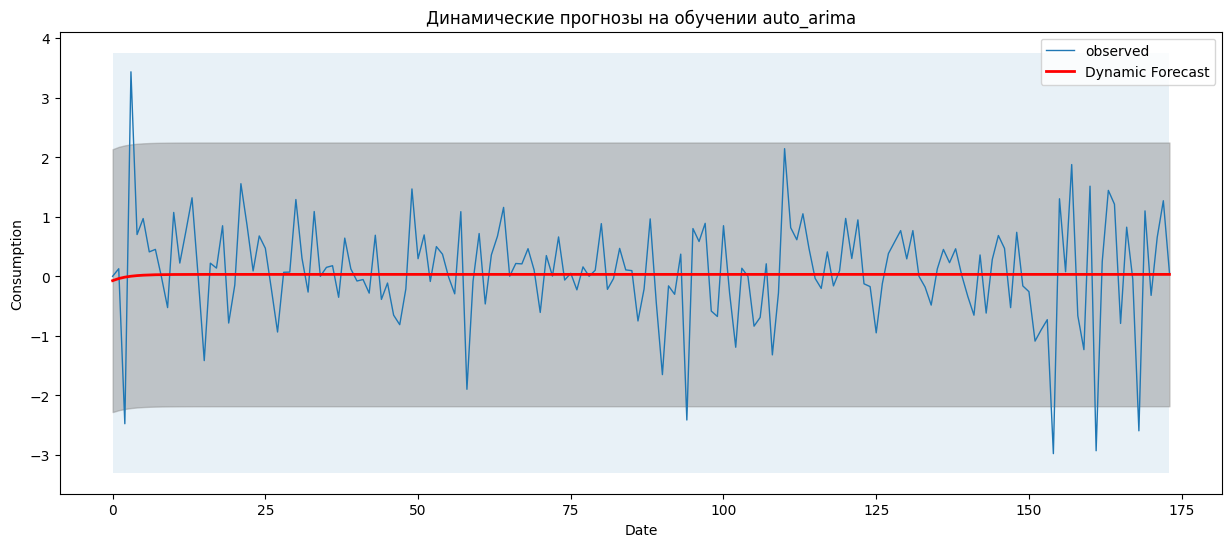

In [54]:
ax = (test.spx_ret).plot(label='observed', figsize=(15, 6), lw=1)
ax.plot(preds.values, label='Dynamic Forecast', lw=2, color='red')
ax.fill_between(test.index, [i[0] for i in ci], [i[1] for i in ci], \
                color='grey', alpha=0.4)
ax.fill_betweenx(ax.get_ylim(), test.index[0], test.index[-1], alpha=0.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Consumption')
plt.title('Динамические прогнозы на обучении auto_arima')
plt.legend()
plt.show()

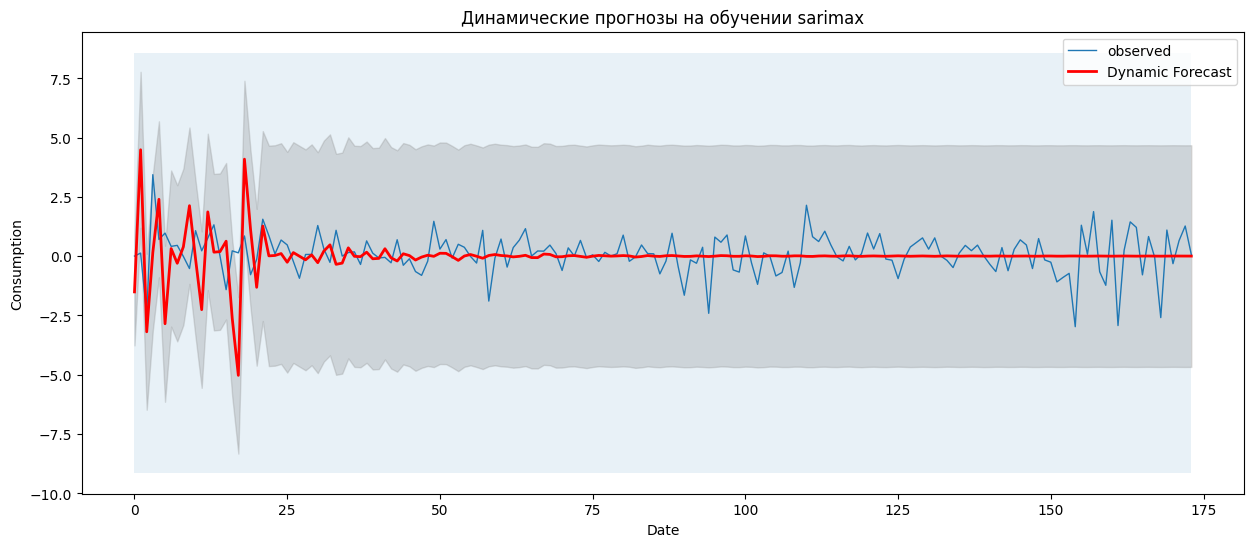

In [55]:
sarx_preds = model.get_forecast(steps = len(test), dynamic=True)
ax = (test.spx_ret).plot(label='observed', figsize=(15, 6), lw=1)
ax.plot(list(sarx_preds.predicted_mean), label='Dynamic Forecast', lw=2, color='red')
ax.fill_between(test.index, sarx_preds.conf_int().iloc[:, 0], \
                sarx_preds.conf_int().iloc[:, 1], \
                color='grey', alpha=0.25)
ax.fill_betweenx(ax.get_ylim(), test.index[0], test.index[-1], alpha=0.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Consumption')
plt.title('Динамические прогнозы на обучении sarimax')
plt.legend()
plt.show()

Посмотрите на остатки модели. Что вы можете сказать о них? Имеет ли смысл применять `GARCH` для их предсказания и почему?

In [56]:
print('остатки', model.resid.mean(), arima.resid().mean())

остатки -0.0016114949435661265 4.486874887274011e-05


In [57]:
print('sarimax\n', 'MSE =', mean_squared_error(test.spx_ret, sarx_preds.predicted_mean), 
      'MAPE =', mean_absolute_percentage_error(test.spx_ret, sarx_preds.predicted_mean) * 100, '%')
print('auto_arima\n', 'MSE =', mean_squared_error(test.spx_ret, preds), 
      'MAPE =', mean_absolute_percentage_error(test.spx_ret, preds) * 100, '%')

sarimax
 MSE = 1.2882597943924177 MAPE = 5207311296449397.0 %
auto_arima
 MSE = 0.7334612022398745 MAPE = 603747506582579.2 %


__4.__ Обучите `GARCH` на остатках модели.

Воспользуйтесь реализацией модели из пакета `arch_model`. [Ссылка](https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html) на примеры и документацию.

In [58]:
arch_model(arima.resid())

Constant Mean(constant: yes, no. of exog: 0, volatility: GARCH(p: 1, q: 1), distribution: Normal distribution), id: 0x7f710829f3d0

In [59]:
arch_model(model.resid)

Constant Mean(constant: yes, no. of exog: 0, volatility: GARCH(p: 1, q: 1), distribution: Normal distribution), id: 0x7f7108aab340

In [60]:
garch = arch_model(arima.resid()).fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1022056939486596.5
Iteration:      2,   Func. Count:     16,   Neg. LLF: 3752423970.1789203
Iteration:      3,   Func. Count:     24,   Neg. LLF: 8741.408332183022
Iteration:      4,   Func. Count:     30,   Neg. LLF: 8744.851934766244
Iteration:      5,   Func. Count:     36,   Neg. LLF: 8776.358058579339
Iteration:      6,   Func. Count:     42,   Neg. LLF: 8639.173106098071
Iteration:      7,   Func. Count:     48,   Neg. LLF: 8715.074558330107
Iteration:      8,   Func. Count:     54,   Neg. LLF: 8628.673048288772
Iteration:      9,   Func. Count:     59,   Neg. LLF: 8628.66420968664
Iteration:     10,   Func. Count:     64,   Neg. LLF: 8628.662608223349
Iteration:     11,   Func. Count:     69,   Neg. LLF: 8628.662186390004
Iteration:     12,   Func. Count:     74,   Neg. LLF: 8628.66218154889
Iteration:     13,   Func. Count:     78,   Neg. LLF: 8628.662181551217
Optimization terminated successfully    (Exit mode 0)
          

In [61]:
garch_sarx = arch_model(model.resid).fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6802497887.529427
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1822772324.846568
Iteration:      3,   Func. Count:     23,   Neg. LLF: 8854.639788399702
Iteration:      4,   Func. Count:     29,   Neg. LLF: 8908.150246941248
Iteration:      5,   Func. Count:     35,   Neg. LLF: 8873.939505821061
Iteration:      6,   Func. Count:     41,   Neg. LLF: 8768.09807998158
Iteration:      7,   Func. Count:     47,   Neg. LLF: 8767.102858917233
Iteration:      8,   Func. Count:     53,   Neg. LLF: 8835.241327952335
Iteration:      9,   Func. Count:     59,   Neg. LLF: 8757.132736394182
Iteration:     10,   Func. Count:     64,   Neg. LLF: 8757.130762915103
Iteration:     11,   Func. Count:     69,   Neg. LLF: 8757.130754914719
Iteration:     12,   Func. Count:     73,   Neg. LLF: 8757.130754914926
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8757.130754914719
            Iterations: 12
  

[]

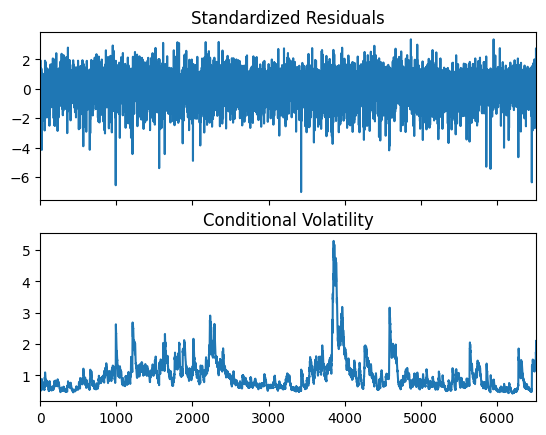

In [62]:
garch.plot()
plt.plot()

[]

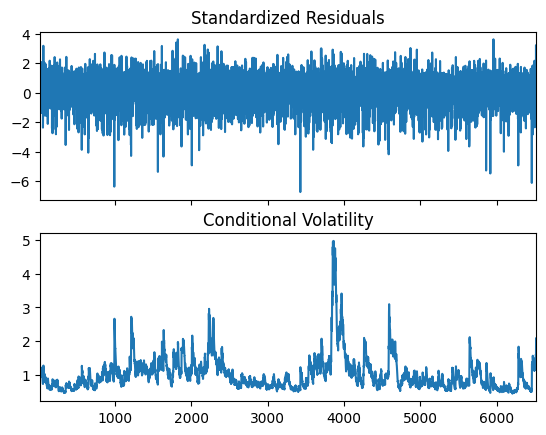

In [63]:
garch_sarx.plot()
plt.plot()

Посмотрите на коэффициенты модели с помощью `.summary()`.

In [64]:
garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8628.66
Distribution:                  Normal   AIC:                           17265.3
Method:            Maximum Likelihood   BIC:                           17292.5
                                        No. Observations:                 6518
Date:                Tue, Mar 21 2023   Df Residuals:                     6517
Time:                        00:21:24   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0380  9.978e-03      3.812  1.380e-04 [1.848e-02,5.759e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0140  3.620e-03      3.856  1.151e-04 [6.865e-03,2.105e-02]
alpha[1]       0.0913  1.200e-02      7.611  2.724e-14   [6.779e-02,  0.115]
beta[1]        0.8980  1.269e-02     70.749      0.000     [  0.873,  0.923]
============================================================================

Covariance estimator: robust
"""

In [65]:
garch_sarx

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8757.13
Distribution:                  Normal   AIC:                           17522.3
Method:            Maximum Likelihood   BIC:                           17549.4
                                        No. Observations:                 6496
Date:                Tue, Mar 21 2023   Df Residuals:                     6495
Time:                        00:21:32   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         6.9663e-03  1.002e-02      0.695      0.487 

__5.__ Постройте доверительный интервал для предсказания `spx` на тесте, комбинируя обученные выше модели, то есть используя предсказания `ARIMA` для среднего и `GARCH` для остатков.

Сделайте выводы.

In [66]:
sarx_garch = np.array(garch_sarx.forecast(horizon=len(test)).variance.values[-1, :])
auto_garch = np.array(garch.forecast(horizon=len(test)).variance.values[-1, :])

ci_sarx_lower = np.array(sarx_preds.predicted_mean) - sarx_garch
ci_arima_lower = np.array(preds) - auto_garch

ci_sarx_upper = np.array(sarx_preds.predicted_mean) + sarx_garch
ci_arima_upper = np.array(preds) + auto_garch

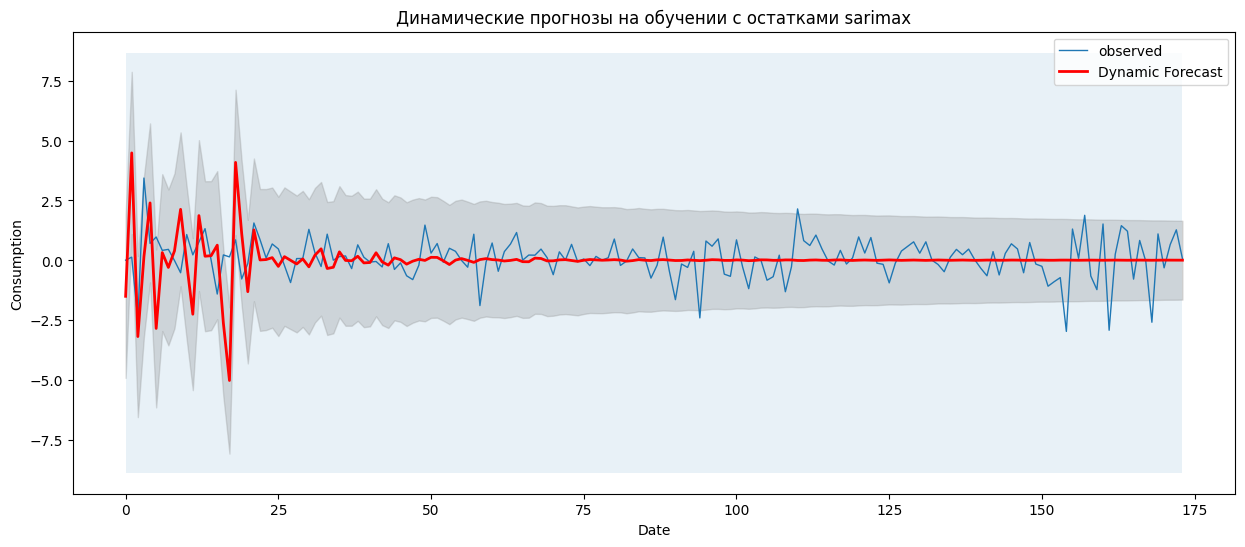

In [67]:
ax = (test.spx_ret).plot(label='observed', figsize=(15, 6), lw=1)
ax.plot(np.array(sarx_preds.predicted_mean), label='Dynamic Forecast', lw=2, color='red')
ax.fill_between(test.index, ci_sarx_lower, \
                ci_sarx_upper, \
                color='grey', alpha=0.25)
ax.fill_betweenx(ax.get_ylim(), test.index[0], test.index[-1], alpha=0.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Consumption')
plt.title('Динамические прогнозы на обучении с остатками sarimax')
plt.legend()
plt.show()

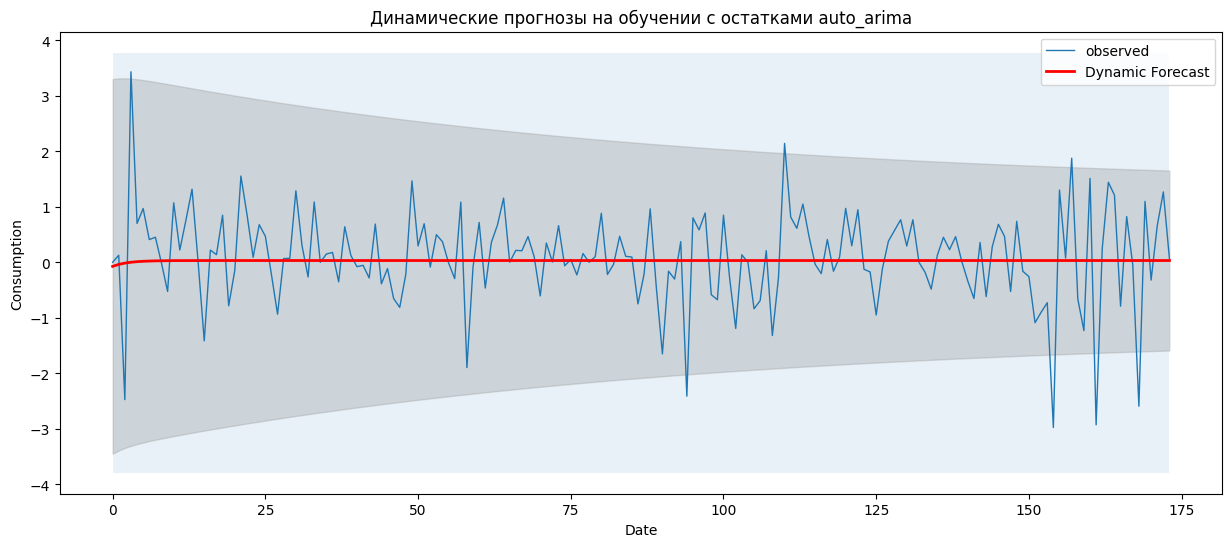

In [68]:
ax = (test.spx_ret).plot(label='observed', figsize=(15, 6), lw=1)
ax.plot(np.array(np.array(preds)), label='Dynamic Forecast', lw=2, color='red')
ax.fill_between(test.index, ci_arima_lower, \
                ci_arima_upper, \
                color='grey', alpha=0.25)
ax.fill_betweenx(ax.get_ylim(), test.index[0], test.index[-1], alpha=0.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Consumption')
plt.title('Динамические прогнозы на обучении с остатками auto_arima')
plt.legend()
plt.show()

Видим, что даже в случаях, когда модель предсказывает константу, мы можем получить адекватный доверительный интервал засчет garch моделей на остатках 